In [1]:
from agent import Agent
from policy import Policy
from action import Action
from state import State
from memory import Memory
from qNetwork import QNetwork

import os
import torch
import gymnasium as gym
from torch import nn

In [2]:
# Policy data
START_EPSILON = 1
DECAY = 0.996
FINAL_EPSILON = 0.01

# Memory data
MEMORY_SIZE = 30_000

# Training settings
NUMBER_OF_EPISODES = 50
DISCOUNT_GAMMA = 0.99
MEMORY_BATCH_SIZE_PER_TRAINING_STEP = 32
NEURAL_NETWORK_BATCH_SIZE = 32
STEP_LIMIT_PER_RUN = 2_000
LOSS_FUNCTION = nn.MSELoss()
OPTIMIZER = torch.optim.Adam
NN_SEED = 42

In [3]:
def train(agent):
    env = gym.make("LunarLander-v2")
    agent.train(
        environment=env,
        n_episodes=NUMBER_OF_EPISODES,
        gamma=DISCOUNT_GAMMA,
        memory_batch_size=MEMORY_BATCH_SIZE_PER_TRAINING_STEP,
        batch_size=NEURAL_NETWORK_BATCH_SIZE,
        steps_limit=STEP_LIMIT_PER_RUN,
        loss_fn=LOSS_FUNCTION,
        optimizer=OPTIMIZER,
        seed=NN_SEED,
        )
    agent.policy.save(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{NEURAL_NETWORK_BATCH_SIZE}-bsz")
    env.close()

Using cpu device



100%|██████████| 50/50 [02:54<00:00,  3.49s/it, current reward=-112, current epsilon=0.818]   

Done training. Final epsilon = 0.8184024506760996


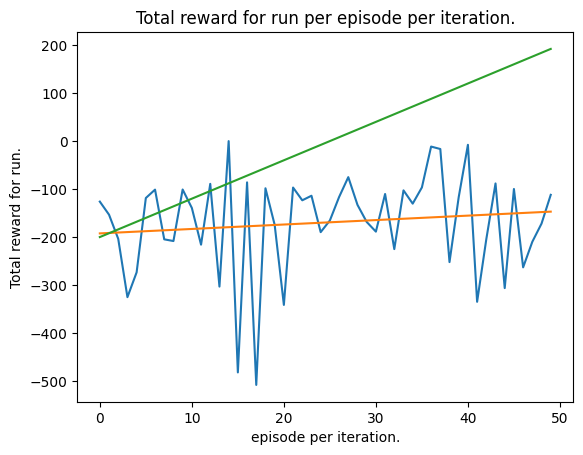

In [4]:
policy = Policy(network=QNetwork(), epsilon=START_EPSILON, decay=DECAY)

memory = Memory(max_size=MEMORY_SIZE)

agent = Agent(policy=policy, memory=memory)

if os.path.exists(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{NEURAL_NETWORK_BATCH_SIZE}-bsz"):
    output = input("You seem to have already trained this model before, want to train it again?\n\t[y]/n?")
    if output in ["yes", "Yes", 'y', 'Y', '']:
        train(agent)
    else:
        exit()
else:
    train(agent)

print(f"Done training. Final epsilon = {agent.policy.epsilon}")
agent.plot()

In [5]:
post_policy = Policy(network=QNetwork(), epsilon=FINAL_EPSILON, decay=DECAY)
post_policy.load(f"saved_models/after_{NUMBER_OF_EPISODES}-eps_{MEMORY_BATCH_SIZE_PER_TRAINING_STEP}-Mbsz_{NEURAL_NETWORK_BATCH_SIZE}-bsz")

post_memory = Memory(max_size=MEMORY_SIZE)
post_agent = Agent(policy=post_policy, memory=post_memory)

Using cpu device



In [9]:
env = gym.make("LunarLander-v2", render_mode="human")
post_agent.run(env)
env.close()